In [44]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as o
import torchvision.transforms as t

from torchsummary import summary

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.plotters import ImagePlotter
from src.utils import *
from src.costs import *
# from src.models.resnet import resnet14_d, resnet14_g
from src.models.resnet2 import ResNet_D, ResNet_G, weights_init_D
from src.train import train


tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport",
                           entity="_devourer_",
                           group="gauss-to-mnist",
#                            mode="offline",
                          )

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(2)
print(DEVICE)

cuda


## Define source and target distributions

In [87]:
n_components = 10
locs = 2 * uniform_circle(n_components)
scales = .3 * torch.ones_like(locs)
source = GaussianMixture(locs, scales, device=DEVICE)

features, classes = load_mnist("../data/",
#                                transform=t.Compose([t.Pad(2), t.ToTensor()])
                               transform=t.Compose([t.Resize(32), t.ToTensor()])
                              )
target = TensorDatasetDistribution(features, classes, device=DEVICE)
p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), p)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [88]:
# critic = resnet18_d(target.event_shape).to(DEVICE)
# summary(critic, target.event_shape, batch_size=512)

# mover = resnet18_g(target.event_shape, p).to(DEVICE)
# summary(mover, (p,), batch_size=512)
critic = ResNet_D(size=32, nc=1).to(DEVICE).apply(weights_init_D)
summary(critic, target.event_shape, batch_size=256)

mover = ResNet_G(p, 32, 1).to(DEVICE)
summary(mover, (p,), batch_size=256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 64, 32, 32]             640
         LeakyReLU-2          [256, 64, 32, 32]               0
            Conv2d-3          [256, 64, 32, 32]          36,928
         LeakyReLU-4          [256, 64, 32, 32]               0
            Conv2d-5          [256, 64, 32, 32]          36,928
         LeakyReLU-6          [256, 64, 32, 32]               0
       ResNetBlock-7          [256, 64, 32, 32]               0
            Conv2d-8         [256, 128, 32, 32]           8,192
            Conv2d-9          [256, 64, 32, 32]          36,928
        LeakyReLU-10          [256, 64, 32, 32]               0
           Conv2d-11         [256, 128, 32, 32]          73,856
        LeakyReLU-12         [256, 128, 32, 32]               0
      ResNetBlock-13         [256, 128, 32, 32]               0
        AvgPool2d-14         [256, 128,

In [95]:
def run_experiment(source, target, mover, critic, cost, n_iter, *,
                   logger=None, **kwargs):
    if logger: 
        logger.start()
        logger.log_hparams(kwargs)
    try:
        train(source, target, mover, critic, cost,
              n_iter=n_iter,
              logger=logger,
              **kwargs)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



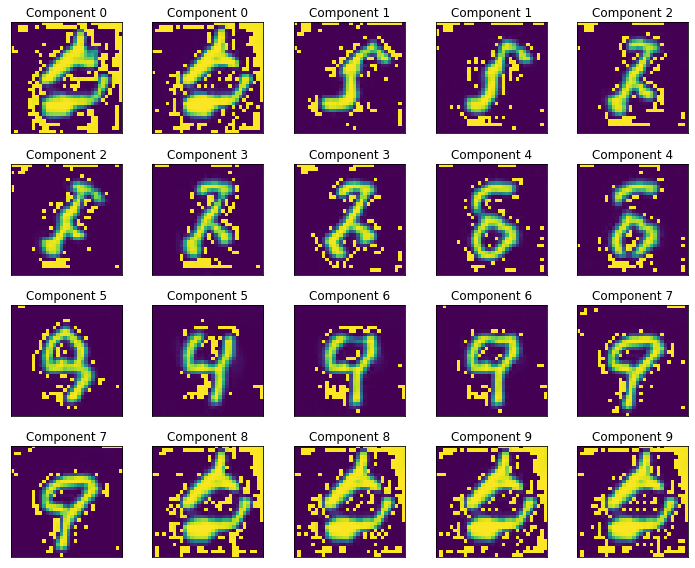

cost,█▁▆▆▆█▇▆▆█▆▇▇▆▆▆█▇▆█▇██████▇▆█▇████▇▇█▇▇
loss,▁▄▇▇█▇███████▇██▇█████████▇█▇███████████
cost,-0.03555
loss,-0.05876


In [98]:
lr = 2e-5

run_experiment(
    source, target, *copy_models(mover, critic),
    n_iter=5000,
    n_samples=64,
#     cost=InnerGW_opt(p, q,
#         optimizer_params=dict(lr=lr, weight_decay=1e-10),
#         n_iter=10,
#         device=DEVICE,
#         init=V.T.to(DEVICE)
#     ),
    cost=InnerGW_exp(V.T.to(DEVICE)),
    plotter=ImagePlotter(plot_interval=100, n_images=20, n_samples=2, plot_source=False),
    logger=wandb_logger,
    n_iter_mover=15,
    optimizer=o.AdamW,
    optimizer_params=dict(lr=lr, weight_decay=1e-10),
)